# Object Detection


In this lab we are detecting the objects and printing out the bounding box coordinates, atlast we are visualize these bounding boxes on top of the image.

## Setup


In [2]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)


2.12.0


### Select and load the model
object detection module.
* [FasterRCNN + InceptionResNet V2](https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1): high accuracy

In [3]:

module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

#### Load the model

Next, we'll load the model

In [4]:
model = hub.load(module_handle)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


#### Choose the default signature



In [5]:
# take a look at the available signatures for this model
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x1E23117F5E0>}))

Choosing the 'default' signature for our object detector.

In [6]:
detector = model.signatures['default']

### download_and_resize_image

Function for downloading an image specified by a given "url", pre-processes it, and then saves it to disk and display the image if you set the parameter `display=True`.

In [7]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256, display=False):
    
    # creating a temporary file
    _, filename = tempfile.mkstemp(suffix=".jpg")
    
    # open URl
    response = urlopen(url)
    
    # reads the image
    image_data = response.read()
    
    # puts the image data 
    image_data = BytesIO(image_data)
    
    # opens the image
    pil_image = Image.open(image_data)
    
    # resizes the image.
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    
    # converts to the RGB Channel
    pil_image_rgb = pil_image.convert("RGB")
    
    # saves the image to the temporary file 
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    
    print("Image downloaded to %s." % filename)
    
    if display:
        display_image(pil_image)

    
    return filename

### Select and load an image


C:\Users\aruna\AppData\Local\Temp\ipykernel_10160\2266519832.py:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)


Image downloaded to C:\Users\aruna\AppData\Local\Temp\tmp0oem3y7f.jpg.


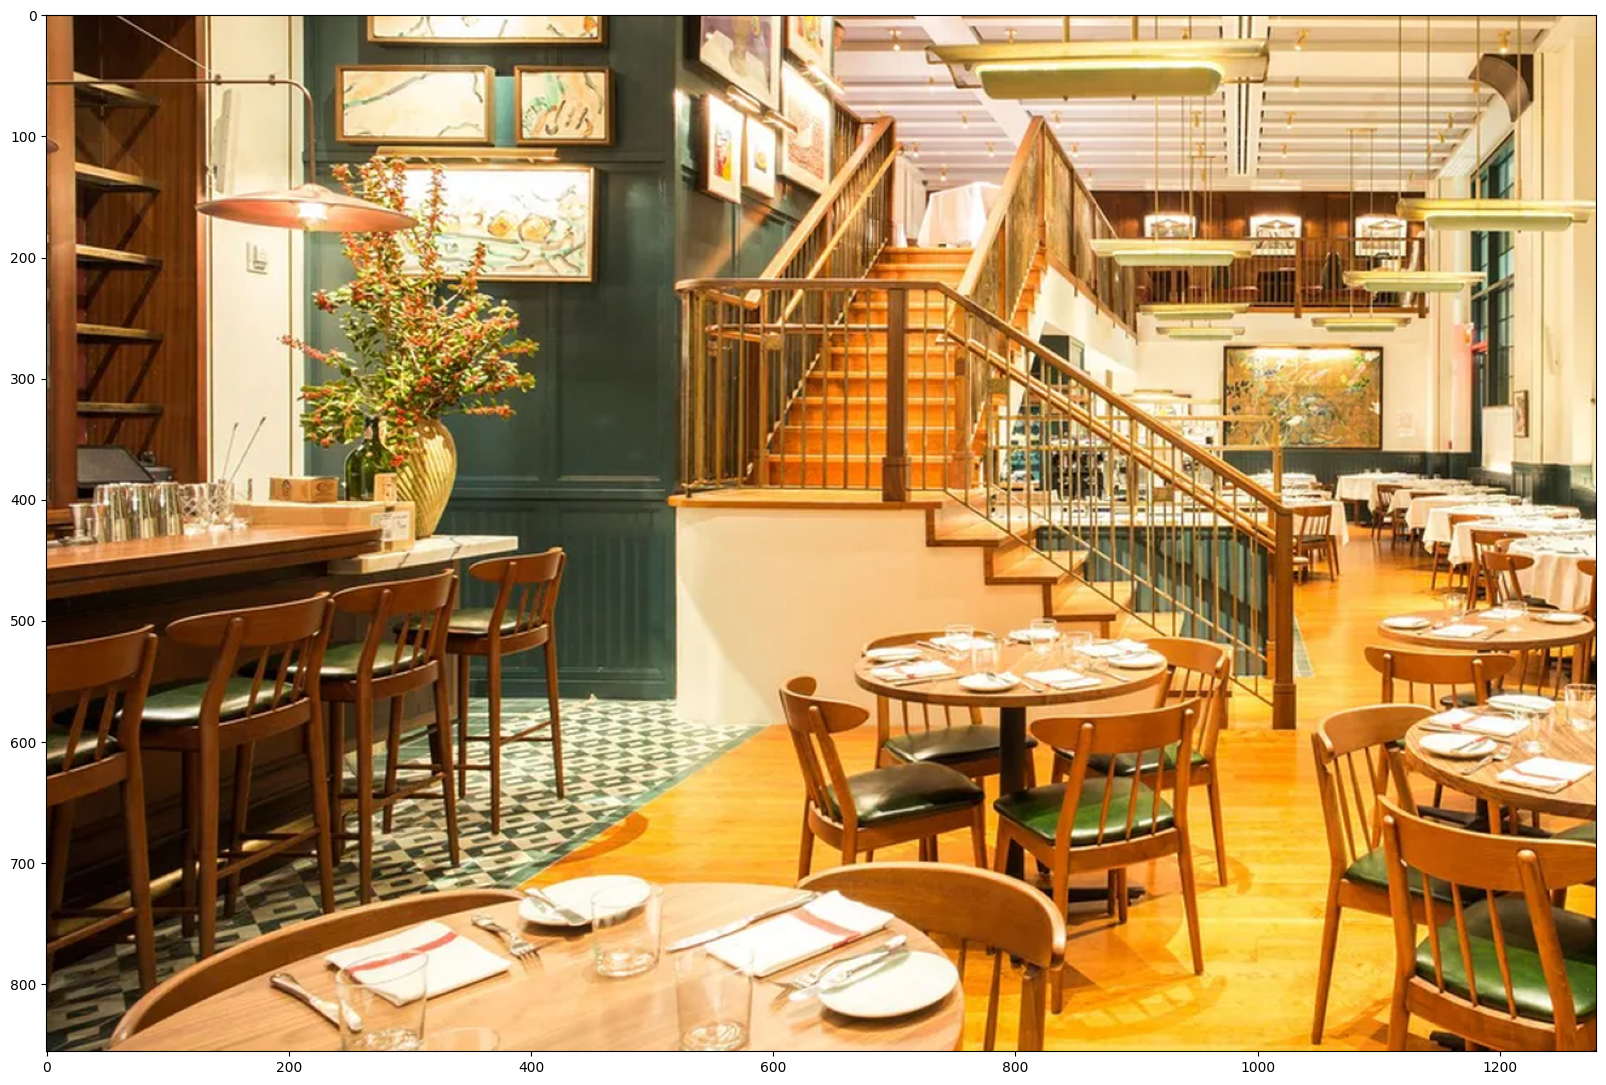

In [10]:
# Danny Meyer's Iconic Union Square Cafe Has Been Reborn, Source: https://cdn.vox-cdn.com/thumbor/FypCg4JdKQdez-IxZZDUEh4N7H8=/0x0:1600x1069/920x613/filters:focal(876x536:1132x792):format(webp)/cdn.vox-cdn.com/uploads/chorus_image/image/52106685/unionsquarecafeNS.0.jpeg
image_url = "https://cdn.vox-cdn.com/thumbor/FypCg4JdKQdez-IxZZDUEh4N7H8=/0x0:1600x1069/920x613/filters:focal(876x536:1132x792):format(webp)/cdn.vox-cdn.com/uploads/chorus_image/image/52106685/unionsquarecafeNS.0.jpeg"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

### Draw bounding boxes

Use `draw_boxes` to do draw bounding boxes and It will use `draw_bounding_box_on_image` to draw the bounding boxes.

In [11]:
def draw_bounding_box_on_image( image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    
    # scaling the bounding box coordinates to the height and width of the image
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    
    # the four edges of the detection box
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)

    # the display strings added to the below the bounding box 
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
        
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)],fill=color)
        draw.text((left + margin, text_bottom - text_height - margin), display_str,fill="black",font=font)
        text_bottom -= text_height - 2 * margin

# returns the image after detection boxes and classes are overlaid on the original image.
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        
        # only display detection boxes that have the minimum score or higher, set the threshold
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

            # drawing the  one bounding box and overlay the class labels onto the image
            draw_bounding_box_on_image(image_pil,ymin,xmin,ymax,xmax,color,font,display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
        
    return image

### Detecting the objects

This function will take in the object detection model `detector` and the path to a sample image, then use this model to detect objects.

In [12]:
def load_img(path):
    
    # read the file
    img = tf.io.read_file(path)
    
    # convert to a tensor
    img = tf.image.decode_jpeg(img, channels=3)
    
    return img


def run_detector(detector, path):
    # load an image tensor 
    img = load_img(path)

    # adding a batch dimension in front of the tensor
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    
    # run inference using the model
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    # saving the results in a dictionary
    result = {key:value.numpy() for key,value in result.items()}

    # printing the results
    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    # draw predicted boxes over the image
    image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

    # display the image
    display_image(image_with_boxes)

### Run the detector on your selected image!

Found 100 objects.
Inference time:  64.14400792121887
Font not found, using default font.


C:\Users\aruna\AppData\Local\Temp\ipykernel_10160\1887588519.py:12: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
C:\Users\aruna\AppData\Local\Temp\ipykernel_10160\1887588519.py:23: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


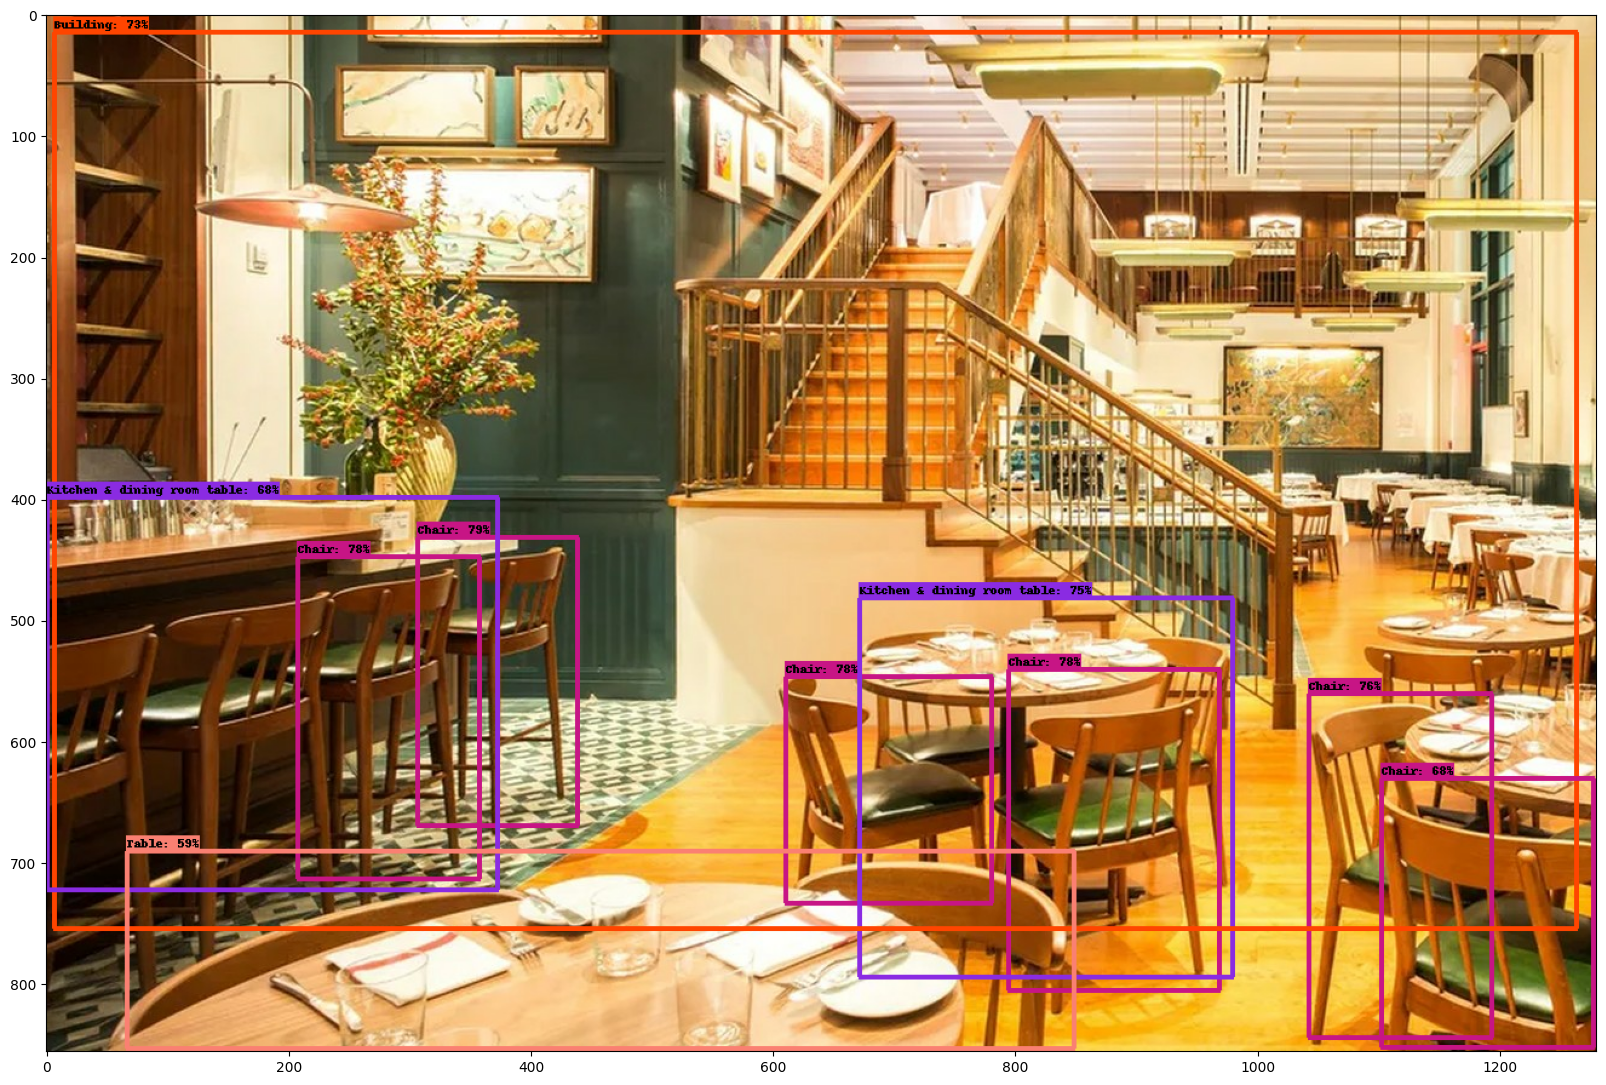

In [13]:
run_detector(detector, downloaded_image_path)

### Run the detector on more images


In [14]:
image_urls = [
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg"
  ]

def detect_img(image_url):
    start_time = time.time()
    image_path = download_and_resize_image(image_url, 640, 480)
    run_detector(detector, image_path)
    end_time = time.time()
    print("Inference time:",end_time-start_time)

C:\Users\aruna\AppData\Local\Temp\ipykernel_10160\2266519832.py:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)


Image downloaded to C:\Users\aruna\AppData\Local\Temp\tmpy4xflj19.jpg.
Found 100 objects.
Inference time:  16.042025804519653
Font not found, using default font.
Inference time: 16.79929494857788


C:\Users\aruna\AppData\Local\Temp\ipykernel_10160\1887588519.py:12: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
C:\Users\aruna\AppData\Local\Temp\ipykernel_10160\1887588519.py:23: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


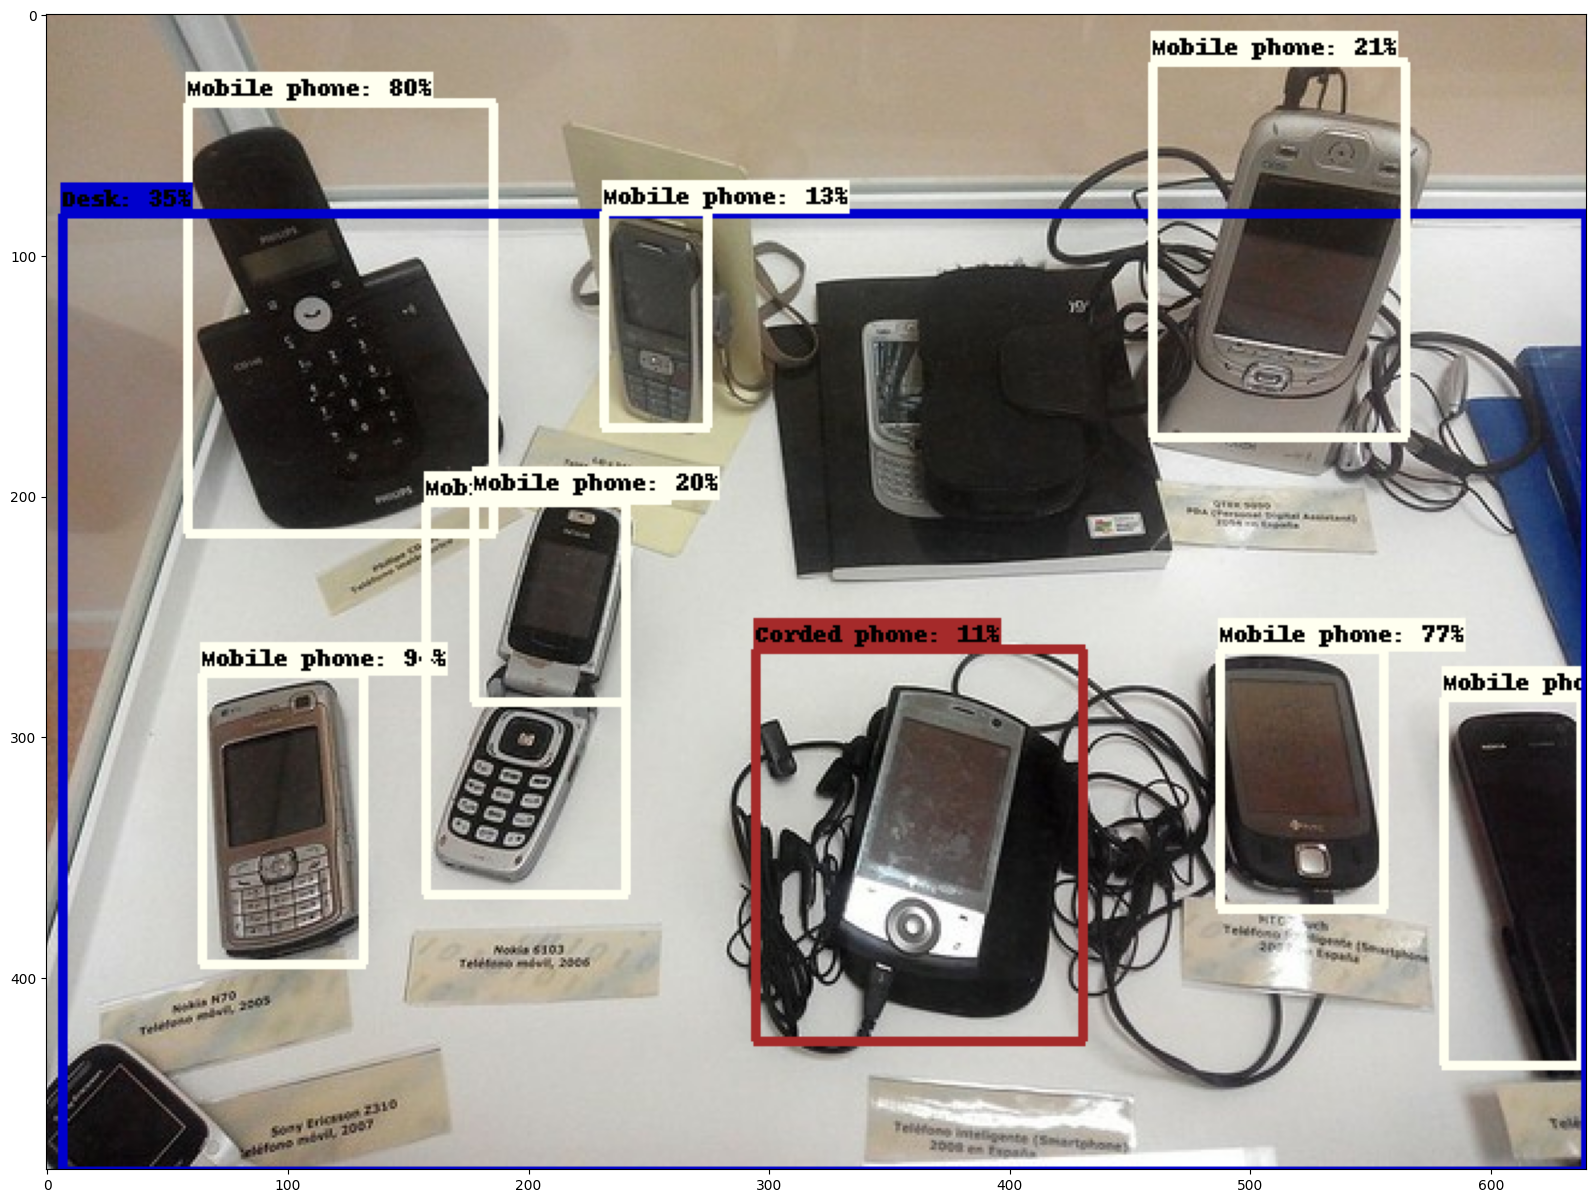

In [16]:
detect_img(image_urls[0])